## Mock MGS tutorial
This tutorial makes mock lightcones from CAMELS-SAM data. The procedure for making the mock lightcones is:
1. Load the CAMELS-SAM galaxy positions and velocities.
2. [Optionally,] randomly rotate and translate the comoving cube to a new orientation and position, for data augmentation.
3. Use [cuboid_remap](https://github.com/maho3/cuboid_remap_jax/tree/main) to reshape the cubic simulation into a long and thin box, which fits the size of the lightcone footprint.
4. Rotate the new cuboid to the desired lightcone orientation and comoving distance.
5. Compute ra-dec-z coordinates from the comoving positions and velocities.
6. Mask the galaxies outside the lightcone footprint.

Steps 3 and 4 use pre-computed information about the real SDSS NYU-VAGC galaxy catalog, namely the median ra-dec-z and the lightcone geometry. These are stored in the XX.txt files, and loaded through the `XX` subroutine in `tools.py`. The pre-computation is done in the `test_camels_to_mgs.ipynb` notebook.

#### Dependencies
The following dependencies are required and can be installed with `pip install XX`:
- scipy
- astropy
- h5py
- jax
- git+https://github.com/maho3/cuboid_remap_jax.git

Note, when installing jax, I would recommend the GPU-less version, i.e. `pip install jax[cpu]`. To install with GPU support, [see these docs](https://jax.readthedocs.io/en/latest/installation.html).

### Background
The SDSS NYU-VAGC catalog is split into four quadrants. You can make a mock for any of the four, but not the whole footprint, as CAMELS-SAM isn't big enough.

![centrals.png](centrals.png)

As a demonstration, we'll first walk through the steps of making the lightcone using a subsample of galaxies. Then, at the end, I've written shorter code to compute this for all galaxies more efficiently.

In [1]:
# imports
%load_ext autoreload
%autoreload 2

import os
os.environ["JAX_ENABLE_X64"] = "True"
from os.path import join
import numpy as np
import matplotlib.pyplot as plt
import h5py
import cuboid_remap as cremap
import jax

from tools import (
    xyz_to_sky, rotate_to_z,
    get_cuboid_lattice_vectors,
    get_median_rdz, get_mean_xyz,
    label_quadrants, random_rotate_translate
)

In [2]:
# Specify the path to the simulation output
path_to_sim = '/home/mattho/git/ltu-connect/camels_data/samout'
print(os.listdir(join(path_to_sim, '0_0_0')))

['files.list', 'param.scsam', 'progress.log', 'tree_offsets.hdf5', 'subvolume.hdf5']


In [3]:
# Specify the simulation cosmology (from param.scsam)
Omega_m = 0.3089
Omega_lambda = 0.6911
h = 0.6774
Omega_b = Omega_m*0.1573

# Put it in quijote format [Omega_m, Omega_b, h, n_s, sigma8]
cosmo = np.array([Omega_m, Omega_b, h, None, None])

# Specify the box size
Lbox = 100  # Mpc/h

In [11]:
# Specify the desired quadrant
Q = 0

# Specify the desired random seed for random
# rotations+translations, i.e. data augmentation
random_seed = 0  # no transformation

# Specify the lightcone footprint (to be replaced with angular masking)
rae = 100, 270     # ra edges (deg)
dece = 0, 70       # dec edges (deg)
ze = 0.01, 0.0335  # redshift edges
zmid = np.mean(ze)  # redshift midpoint

In [7]:
# Setup cuboid remap transformation
u1, u2, u3 = get_cuboid_lattice_vectors()
C = cremap.Cuboid(u1, u2, u3)
transform = jax.vmap(C.Transform, in_axes=0)
boxL = np.array(cremap.remap_Lbox(u1, u2, u3))*Lbox

# Setup the rotation matrices (for quadrant)
median_rdz = get_median_rdz(Q)
rot, rot_inv = rotate_to_z(median_rdz, cosmo)

# Setup mean comoving (for quadrant)
mean_xyz = get_mean_xyz(Q)

In [8]:
# Specify CAMELS-SAM subvolumes
idxs = np.array(np.meshgrid(*[[0,1]]*3)).reshape(3,-1).T
print('Subvolumes:\n', idxs)

Subvolumes:
 [[0 0 0]
 [0 0 1]
 [1 0 0]
 [1 0 1]
 [0 1 0]
 [0 1 1]
 [1 1 0]
 [1 1 1]]


In [19]:
# Find optimal snapshot redshift (closest to zmid)
idx = idxs[0]
with h5py.File(join(path_to_sim, '_'.join(map(str, idx)), 'subvolume.hdf5'), 'r') as f:
    # print(f['Galprop'].keys())
    galzs = f['Galprop']['GalpropRedshift'][:]
galzs = np.unique(galzs)
zidx = np.argmin(np.abs(galzs - zmid))
zsnap = galzs[zidx]
print(f'Desired midpoint redshift: {zmid:.6f}')
print(f'Optimal snapshot redshift: {zsnap:.6f}')

Desired midpoint redshift: 0.021750
Optimal snapshot redshift: 0.023374


In [25]:
subsample = 0.5  # optionally subsample the galaxies, for speed

# process each subvolume in serial, to save memory
rdz_list = []   # ra-dec-z
mask_list = []  # mask
for idx in idxs:
    print(f'Running subvolume {idx}...')

    # 1. Load the galaxy positions and velocities
    with h5py.File(join(path_to_sim, '_'.join(map(str, idx)), 'subvolume.hdf5'), 'r') as f:
        # only choose galaxies in the desired snapshot
        mask = (f['Galprop']['GalpropRedshift'][:] == zsnap)
        # optionally subsample
        mask &= np.random.rand(f['Galprop']['GalpropPos'].shape[0]) < subsample
        gpos = f['Galprop']['GalpropPos'][mask]      # Mpc
        gvel = f['Galprop']['GalpropVel'][mask]      # km/s
    gpos *= h # convert to Mpc/h
    gpos %= Lbox  # periodic boundary conditions


    # 2. Randomly rotate and translate, optional
    gpos, gvel = random_rotate_translate(gpos, Lbox, gvel, random_seed)


    # 3. Remap to cuboid
    gpos = transform(gpos/Lbox)*Lbox
    gpos += mean_xyz - boxL/2  # center the cuboid
    gvel = C.TransformVelocity(gvel).T


    # 4. Rotate to desired lightcone position
    gpos = rot_inv.apply(gpos)
    gvel = rot_inv.apply(gvel)


    # 5. Compute ra-dec-z
    grdz = xyz_to_sky(gpos, gvel, cosmo)


    # 6. Compute mask
    mask = np.ones(len(grdz), dtype=bool)
    mask &= (grdz[:,0] > rae[0]) & (grdz[:,0] < rae[1])    # ra bounds
    mask &= (grdz[:,1] > dece[0]) & (grdz[:,1] < dece[1])  # dec bounds
    mask &= (grdz[:,2] > ze[0]) & (grdz[:,2] < ze[1])      # z bounds
    mask &= label_quadrants(grdz[:,0], grdz[:,1]) == Q     # quadrant


    # Save
    rdz_list.append(grdz)
    mask_list.append(mask)

# Combine
grdz = np.concatenate(rdz_list)
mask = np.concatenate(mask_list)

Running subvolume [0 0 0]...
Running subvolume [0 0 1]...
Running subvolume [1 0 0]...
Running subvolume [1 0 1]...
Running subvolume [0 1 0]...
Running subvolume [0 1 1]...
Running subvolume [1 1 0]...
Running subvolume [1 1 1]...


Text(0.5, 0, 'z')

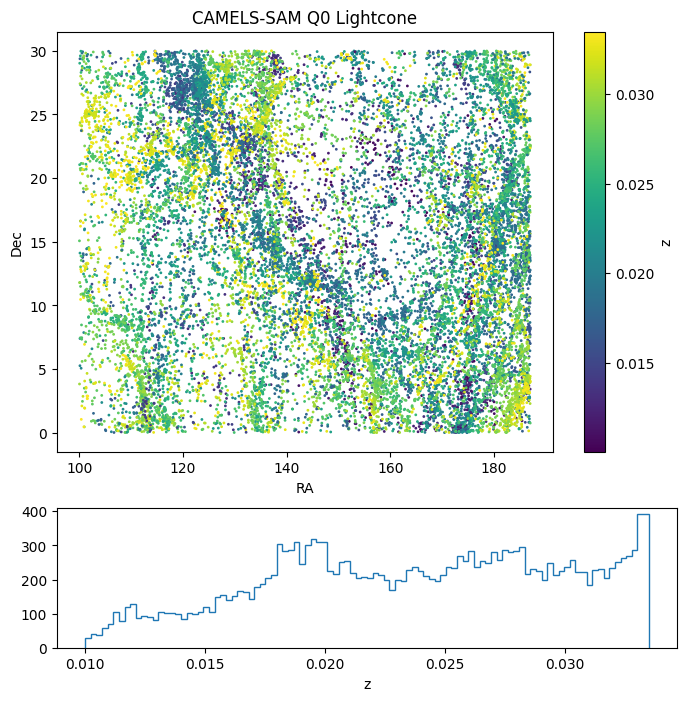

In [26]:
f, axs = plt.subplots(
    2,1, figsize=(8,8),
    gridspec_kw=dict(height_ratios=[3,1])
)
                      
ax = axs[0]
im = ax.scatter(grdz[mask,0], grdz[mask,1], c=grdz[mask,2], s=1)
ax.set_xlabel('RA')
ax.set_ylabel('Dec')
ax.set_title(f'CAMELS-SAM Q{Q} Lightcone')
plt.colorbar(im, label='z')

ax = axs[1]
ax.hist(grdz[mask,2], bins=100, histtype='step')
ax.set_xlabel('z')

## Further notes

There are still a few things todo here:
- Add real angular selection of the SDSS footprint, instead of square cutout.
- Add capacity to rotate the box prior to lightcone construction, for data augmentation.